In [1]:
import msprime as msp
from demestats.loglik.sfs_loglik import prepare_projection, projection_sfs_loglik
from demestats.sfs import ExpectedSFS
import jax
import jax.numpy as jnp

## Simulating IWM model

In [2]:
demo = msp.Demography()
demo.add_population(initial_size=5000, name="anc")
demo.add_population(initial_size=5000, name="P0")
demo.add_population(initial_size=5000, name="P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.0001)
demo.add_population_split(time=1000, derived=["P0", "P1"], ancestral="anc")

sample_size = 10
samples = {"P0": sample_size, "P1": sample_size}
ts = msp.sim_mutations(
    msp.sim_ancestry(
        samples=samples, demography=demo,
        recombination_rate=1e-8, sequence_length=1e8, random_seed=12
    ),
    rate=1e-8, random_seed=13
)

afs_samples = {"P0": sample_size * 2, "P1": sample_size * 2}
afs = ts.allele_frequency_spectrum(
    sample_sets=[ts.samples([1]), ts.samples([2])],
    span_normalise=False,
    polarised = True
)

In [3]:
sequence_length = None
num_projections = 200
seed = 50 

proj_dict, einsum_str, input_arrays = prepare_projection(afs, afs_samples, sequence_length, num_projections, seed)

## Computing the projected SFS

In [4]:
paths = {frozenset({('demes', 0, 'epochs', 0, 'end_size'),
            ('demes', 0, 'epochs', 0, 'start_size')}):3000.,
        frozenset({('demes', 1, 'epochs', 0, 'end_size'),
            ('demes', 1, 'epochs', 0, 'start_size')}): 6000.,
        frozenset({('demes', 2, 'epochs', 0, 'end_size'),
            ('demes', 2, 'epochs', 0, 'start_size')}): 4000.}

esfs_obj = ExpectedSFS(demo.to_demes(), num_samples=afs_samples)
lowdim_esfs = esfs_obj.tensor_prod(proj_dict, paths)

2026-01-16 15:48:35.849 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Split2(donor='P0', recipient='anc'), 'block': frozenset({'anc', 'P1'}), 't': ('demes', 1, 'start_time'), 'ti': 0}
2026-01-16 15:48:35.850 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time'), 'ti': 1}
2026-01-16 15:48:35.851 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time'), 'ti': 1}
2026-01-16 15:48:35.852 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Split2(donor='P0', recipient='anc'), 'block': frozenset({'anc', 'P1'}), 't': ('demes', 1, 'start_time'), 'ti': 0}
2026-01-16 15:48:36.890 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Split1(donor='P1', recipient='anc'), 'block': frozenset({'anc'}), 't': ('demes', 2, 'start_time'), 'ti': 0

## Projected loglikelihood

In [11]:
from demestats.loglik.sfs_loglik import projection_sfs_loglik

mult_ll = projection_sfs_loglik(esfs_obj, paths, proj_dict, einsum_str, input_arrays)
print(mult_ll)

-25661634.0


In [12]:
pois_ll = projection_sfs_loglik(esfs_obj, paths, proj_dict, einsum_str, input_arrays, sequence_length=1e-8, theta=1e-8)
print(pois_ll)

-133359300.0


## Differentiable loglikelihood

In [5]:
param_key = frozenset({('migrations', 0, 'rate')})

@jax.value_and_grad
def ll_at(val):
    params = {param_key: val}
    return projection_sfs_loglik(esfs_obj, params, proj_dict, einsum_str, input_arrays, sequence_length=None, theta=None)

val = 0.0002
loglik_value, loglik_grad = ll_at(val)

print("Log-likelihood at rate =", val, "is", loglik_value)
print("Gradient at rate =", val, "is", loglik_grad)

2026-01-16 15:48:43.053 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Split2(donor='P0', recipient='anc'), 'block': frozenset({'anc', 'P1'}), 't': ('demes', 1, 'start_time'), 'ti': 0}
2026-01-16 15:48:43.054 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time'), 'ti': 1}
2026-01-16 15:48:43.055 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time'), 'ti': 1}
2026-01-16 15:48:43.060 | DEBUG    | demestats.traverse:traverse:151 - halted at parent={'event': Split2(donor='P0', recipient='anc'), 'block': frozenset({'anc', 'P1'}), 't': ('demes', 1, 'start_time'), 'ti': 0}
2026-01-16 15:48:43.069 | DEBUG    | demestats.sfs.migration:lift_cm:69 - using diffeq solver for lift
2026-01-16 15:48:43.814 | DEBUG    | demestats.sfs.migration:lift_cm:69 - using diffeq solver for lif

Log-likelihood at rate = 0.0002 is -25659996.0
Gradient at rate = 0.0002 is -11858120.0


## Plotting loglikelihood curve

W0116 15:49:03.386653 3365224 gemm_fusion_autotuner.cc:1053] Compiling 16 configs for 3 fusions on a single thread.


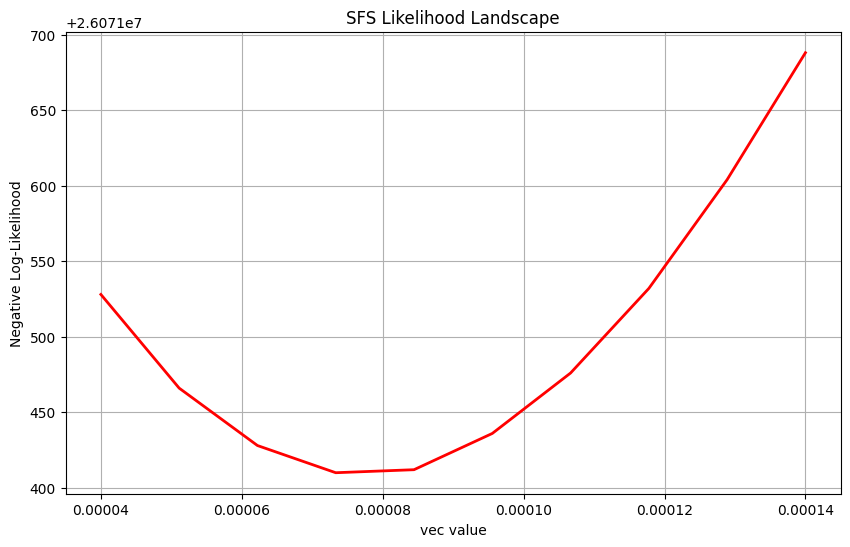

In [6]:
from demestats.fit.plotting_util import plot_sfs_likelihood

paths = {
  frozenset({("migrations", 0, "rate")}): 0.0001,
}

vec_values = jnp.linspace(0.00004, 0.00014, 10)
result = plot_sfs_likelihood(demo.to_demes(), paths, vec_values, afs, afs_samples, num_projections=200, seed=5, projection=True)

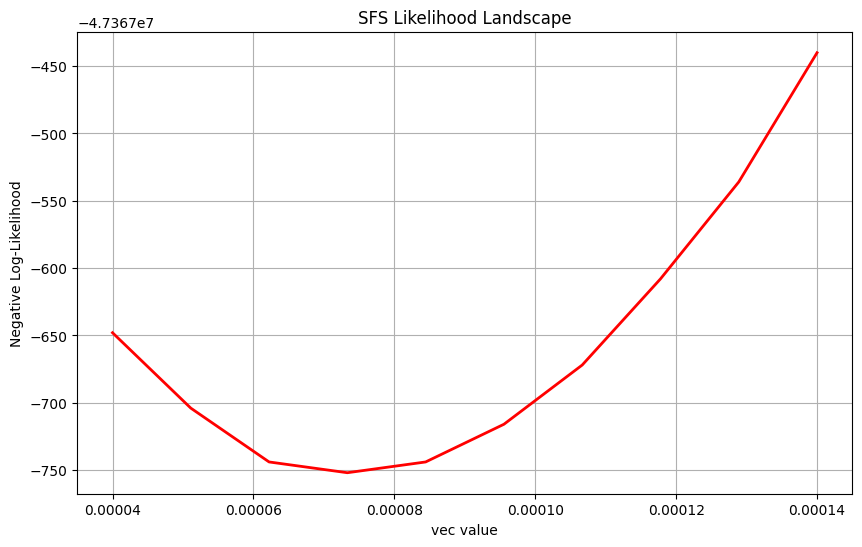

In [7]:
paths = {
  frozenset({("migrations", 0, "rate")}): 0.0001,
}

vec_values = jnp.linspace(0.00004, 0.00014, 10)
sequence_length = 1e8
theta = 1e-8
result = plot_sfs_likelihood(demo.to_demes(), paths, vec_values, afs, afs_samples, num_projections=200, seed=5, projection=True, sequence_length=sequence_length, theta=theta)

## Loglikelihood contour plot

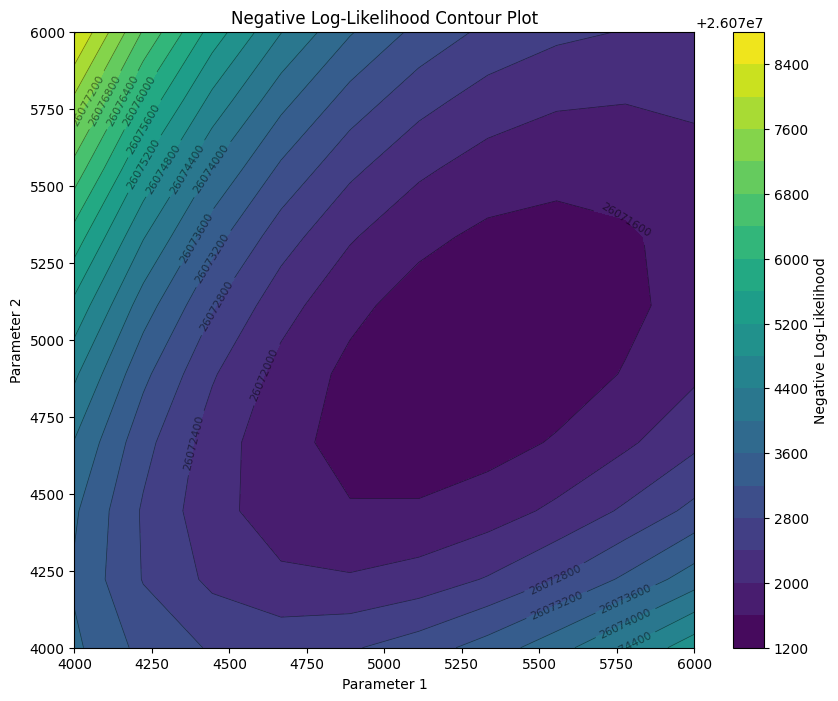

In [9]:
from demestats.fit.plotting_util import plot_sfs_contour

paths = {
    frozenset({
        ("demes", 1, "epochs", 0, "end_size"),
        ("demes", 1, "epochs", 0, "start_size"),
    }): 4000.,
    frozenset({
        ("demes", 2, "epochs", 0, "end_size"),
        ("demes", 2, "epochs", 0, "start_size"),
    }): 4000.,
}

param1_vals = jnp.linspace(4000, 6000, 10)
param2_vals = jnp.linspace(4000, 6000, 10)

result = plot_sfs_contour(demo.to_demes(), paths, param1_vals, param2_vals, afs, afs_samples, projection=True, num_projections=200, seed=5)